# **Style Transfer Custom Images**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**

_________________________
**Accessing Dataset**

In [1]:
cd ..

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning


In [2]:
cd datasets

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning/datasets


_________

In [3]:
# important libraries

# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import torchvision and transformations libraries
import torchvision as tv
import torchvision.transforms as T

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [4]:
# import alex19 and freeze all the layers

alex=tv.models.alexnet(weights=tv.models.AlexNet_Weights.DEFAULT)

# freeze all layers 
for p in alex.parameters():
    p.requires_grad_(False)

# set to evaluation mode
alex.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# send the net to GPU if available
device=tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
alex.to(device);

In [7]:
# importing the images

img4style = plt.imread('images/StarryNight.jpg')
img4content  = plt.imread('images/DP2.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(3472, 4640, 3)
(3472, 4640, 3)
(373, 696, 3)


In [8]:
## These images are really large, which will make training take a long time. 

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(512),
                 # Normalization done because alex takes in normalized images
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content).unsqueeze(0).to(device)
img4style   = Ts( img4style  ).unsqueeze(0).to(device)
img4target  = Ts( img4target ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 512, 684])
torch.Size([1, 3, 512, 684])
torch.Size([1, 3, 512, 955])


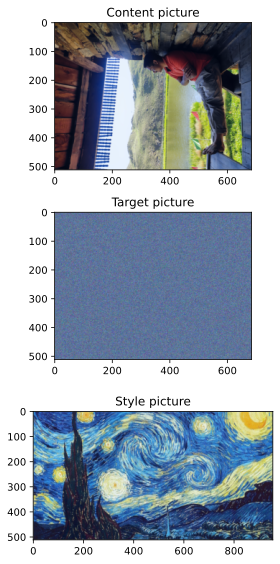

In [9]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(3,1,figsize=(4,8))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')
plt.tight_layout()
plt.show()

In [10]:
# function to extract the image feature map activations

def getFeatureMapActs(img,net):

    # initialize the feature maps as a list
    featureMaps=[]
    featureNames=[]

    convLayerIdx=0

    # loop through all layers in the "features" block
    for layernum in range(len(net.features)):

        # print out info from this layer
        # print(layernum,net.features[layernum])

        # process the image through this layer
        img=net.features[layernum](img)

        # store the image if it is conv-2d layer
        if 'Conv2d' in str(net.features[layernum]):
            featureMaps.append(img)
            featureNames.append(f'ConvLayer_{convLayerIdx}')
            convLayerIdx+=1
    return featureMaps,featureNames

In [11]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(M):
    # reshape to 2D
    _,chans,height,width=M.shape
    M=M.reshape(chans,height*width)

    # compute and return covariance matrix
    gram=tr.mm(M,M.t()) / (chans*height*width)
    ### mm --> matrix multiplication
    return gram

In [12]:
# inspect the output of the function
featmaps,featnames=getFeatureMapActs(img4content,alex)

# print out some info
for i in range(len(featnames)):
    print(f'Feature map "{featnames[i]}" is size {featmaps[i].shape}')

Feature map "ConvLayer_0" is size torch.Size([1, 64, 127, 170])
Feature map "ConvLayer_1" is size torch.Size([1, 192, 63, 84])
Feature map "ConvLayer_2" is size torch.Size([1, 384, 31, 41])
Feature map "ConvLayer_3" is size torch.Size([1, 256, 31, 41])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 31, 41])


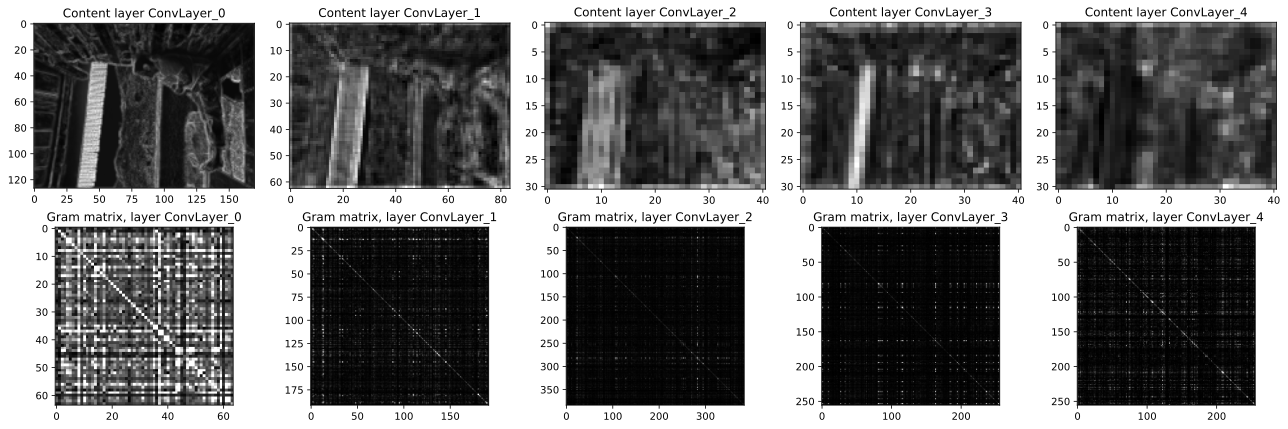

In [13]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,alex)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

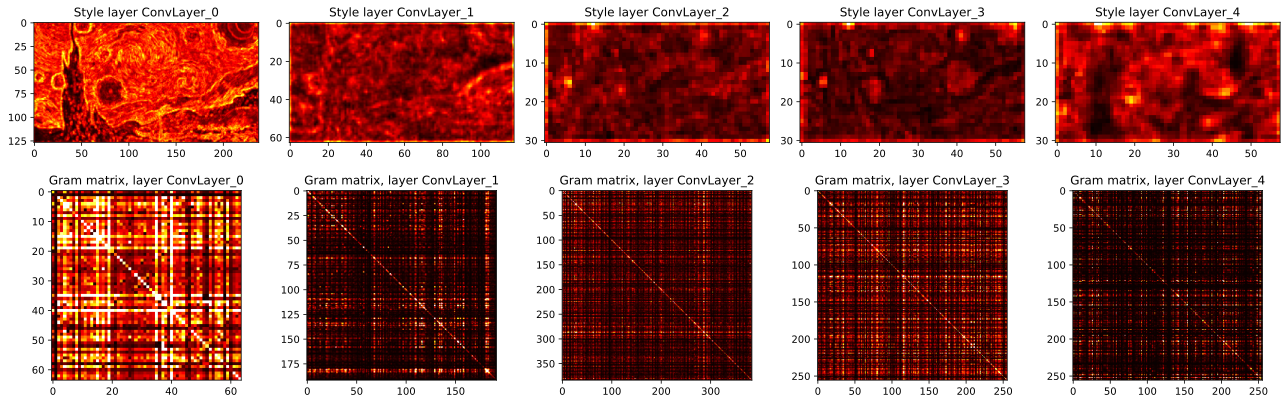

In [14]:

# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,alex)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='hot')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='hot',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

In [15]:
# Performing the style transfer

# which layers to use 
layers4content  = ['ConvLayer_0','ConvLayer_1']
layers4style    = ['ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5','ConvLayer_6']
weights4style   = [     1,            1,            .6,          .4,         .2,        .1         ]

In [44]:
# make a copy of the target image and push to GPU
target=img4target.clone()
target.requires_grad=True
target=target.to(device)
styleScaling=3e5    # higher this number, more is the style transfer

# number of epochs to train
numepochs=2000

# optimizer for backprop
optimizer=tr.optim.RMSprop([target],lr=0.001) # recommended by the developer of style transfer

for epochi in range(numepochs):
    # extract the target feature maps
    targetFeatureMaps,targetFeatureNames=getFeatureMapActs(target,alex)

    # initialize the individual loss components
    styleLoss=0
    contentLoss=0

    # loop over layers
    for layeri in range(len(targetFeatureNames)):
        # compute the content loss
        if targetFeatureNames[layeri] in layers4content:
            contentLoss+=tr.mean((targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2)

        if targetFeatureNames[layeri] in layers4style:
            # Gram Matrices
            Gtarget=gram_matrix(targetFeatureMaps[layeri])
            Gstyle=gram_matrix(styleFeatureMaps[layeri])
            
            # compute their loss (de-weighted with increasing depth)
            styleLoss += tr.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

    # combined loss 
    combiloss=styleScaling*styleLoss+contentLoss

    # finally ready for backprop!
    optimizer.zero_grad()
    combiloss.backward()
    optimizer.step()
    print(f'{epochi+1}/{numepochs} complete!!!')

1/2000 complete!!!
2/2000 complete!!!
3/2000 complete!!!
4/2000 complete!!!
5/2000 complete!!!
6/2000 complete!!!
7/2000 complete!!!
8/2000 complete!!!
9/2000 complete!!!
10/2000 complete!!!
11/2000 complete!!!
12/2000 complete!!!
13/2000 complete!!!
14/2000 complete!!!
15/2000 complete!!!
16/2000 complete!!!
17/2000 complete!!!
18/2000 complete!!!
19/2000 complete!!!
20/2000 complete!!!
21/2000 complete!!!
22/2000 complete!!!
23/2000 complete!!!
24/2000 complete!!!
25/2000 complete!!!
26/2000 complete!!!
27/2000 complete!!!
28/2000 complete!!!
29/2000 complete!!!
30/2000 complete!!!
31/2000 complete!!!
32/2000 complete!!!
33/2000 complete!!!
34/2000 complete!!!
35/2000 complete!!!
36/2000 complete!!!
37/2000 complete!!!
38/2000 complete!!!
39/2000 complete!!!
40/2000 complete!!!
41/2000 complete!!!
42/2000 complete!!!
43/2000 complete!!!
44/2000 complete!!!
45/2000 complete!!!
46/2000 complete!!!
47/2000 complete!!!
48/2000 complete!!!
49/2000 complete!!!
50/2000 complete!!!
51/2000 c

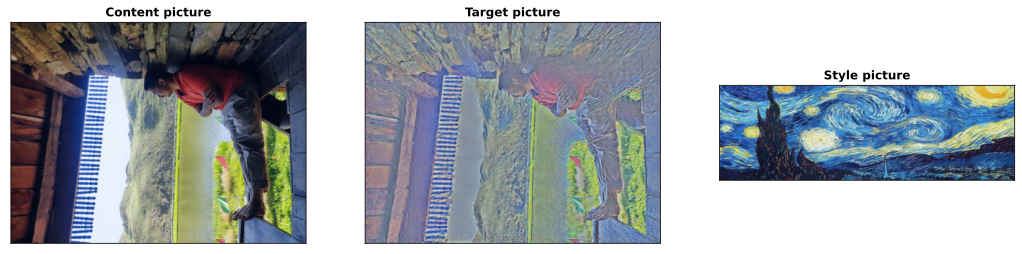

In [45]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])


# pic = target.cpu().detach().squeeze().numpy().transpose((1,2,0))
pic = tr.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

In [46]:
img=tr.squeeze(target).detach().numpy().transpose(2,1,0)
img=(img-img.min())/(img.max()-img.min())
plt.imsave("style_transfered_dp.jpg",img)